# Data completion task

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
import warnings
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

The dataset contains some missing values in the gender and yob columns, some rows are missing one of these two features, some are missing both. The goal is to fill the missing values in gender and yob.

In [2]:
initial_df=pd.read_csv("user_exo_2M.csv")
print(initial_df.head())

    yob        domain        firstname  zipcode gender
0  1985   @wanadoo.fr  b08253b305fb5ec  94450.0      F
1  1961       @sfr.fr  7ff135854376850  78580.0      M
2  1977      @free.fr  172522ec1028ab7  62640.0    NaN
3    -1  @hotmail.com  d3ca5dde60f88db  94100.0      M
4    -1    @gmail.com  bdaae16837dd576  78100.0    NaN


The features domain, firstname and zipcode are categorical data, Their cardinality is as follows

In [3]:
print('number of possible categories in domain : ',len(initial_df.domain.unique()))
print('number of possible categories in zipcodes : ',len(initial_df.zipcode.unique()))
print('number of possible categories in firstnames : ',len(initial_df.firstname.unique()))

number of possible categories in domain :  43
number of possible categories in zipcodes :  2316
number of possible categories in firstnames :  15682


We convert them to category type data

In [4]:
initial_df['domain']=initial_df['domain'].astype('category')
initial_df['zipcode']=initial_df['zipcode'].astype('category')
initial_df['firstname']=initial_df['firstname'].astype('category')
initial_df['gender']=initial_df['gender'].astype('category')
print(initial_df.dtypes)

yob             int64
domain       category
firstname    category
zipcode      category
gender       category
dtype: object


Let us check if there are missing values, other than gender values.

In [5]:
np.sum(initial_df.isna())

yob               0
domain            0
firstname         0
zipcode       17194
gender       804954
dtype: int64

Since it is known that there are missing values on the gender feature, we will impute the zipcode variables. The imputation strategy is to take an element from existing zipcodes, with their actual distribution. We impute with a random value from the list of zipcodes, where zipcodes can be counted multiple times. With this, the chosen zipcode to fill the values follows the distribution of the known zipcodes, where the most frequent zipcode has the highest chances to be picked. 

In [6]:
zipcodes=list(initial_df.zipcode[initial_df.zipcode.isna()==False])
initial_df['zipcode'].fillna(np.random.choice(zipcodes),inplace=True)
print(np.sum(initial_df.isna()))

yob               0
domain            0
firstname         0
zipcode           0
gender       804954
dtype: int64


In [7]:
print(initial_df.head(10))
print(initial_df.shape)

    yob        domain        firstname  zipcode gender
0  1985   @wanadoo.fr  b08253b305fb5ec  94450.0      F
1  1961       @sfr.fr  7ff135854376850  78580.0      M
2  1977      @free.fr  172522ec1028ab7  62640.0    NaN
3    -1  @hotmail.com  d3ca5dde60f88db  94100.0      M
4    -1    @gmail.com  bdaae16837dd576  78100.0    NaN
5  1975   @wanadoo.fr  57c2877c1d84c4b  92600.0      M
6  1974    @gmail.com  d47de916cacd0b7  65200.0      M
7  1957      @free.fr  7ff135854376850  83250.0    NaN
8    -1      @live.fr  a5410ee37744c57   5100.0      M
9    -1   @wanadoo.fr  60784186ea5b29f  68300.0    NaN
(2000000, 5)


After this, we need to encode our categorical features in order to feed them to the models later. Since their cardinality is kind of high, we choose an ordinal encoding for them.

In [8]:
from sklearn.preprocessing import OrdinalEncoder
df = initial_df
cols=['domain','zipcode','firstname']
for c in cols:
        df.loc[:,c] = OrdinalEncoder().fit_transform(np.asarray(df[c]).reshape(-1,1))

We then divide our dataset into 4 groups : data missing only yob, data missing only gender, data missing both, and data that doesn't miss any value.

In [9]:
cond1 = (df.yob==-1) & [not(x) for x in df.gender.isna()]
cond2 = (df.yob!=-1) & (df.gender.isna())
cond3 = [not(x) for x in (df.yob==-1) | (df.gender.isna())]
cond4 = (df.yob==-1) & (df.gender.isna())
missing_yob = df[cond1]
missing_gender = df[cond2]
complete_df = df[cond3]
missing_both = df[cond4]

In [10]:
print(missing_gender)
print(missing_yob)
print(missing_both)
print(complete_df)

          yob  domain  firstname  zipcode gender
2        1977    10.0     1393.0   1373.0    NaN
7        1957    10.0     7717.0   1948.0    NaN
12       1980    39.0    13318.0    626.0    NaN
17       1965    10.0     2629.0    530.0    NaN
22       1977    41.0     7518.0   1686.0    NaN
...       ...     ...        ...      ...    ...
1999977  1980    11.0      791.0   2105.0    NaN
1999982  1958    11.0    11132.0    565.0    NaN
1999987  1994    17.0    11047.0   1801.0    NaN
1999992  1979    11.0    12416.0   1686.0    NaN
1999997  1998    11.0      134.0    328.0    NaN

[403281 rows x 5 columns]
         yob  domain  firstname  zipcode gender
3         -1    16.0    12922.0   2214.0      M
8         -1    24.0    10046.0     73.0      M
13        -1    10.0    13172.0    366.0      M
18        -1    33.0     6742.0   1658.0      M
23        -1    17.0      829.0   2096.0      M
...      ...     ...        ...      ...    ...
1999978   -1    33.0    10392.0   1688.0      F
1

We can see their respective shapes, and verify that our decomposition is a partition of the whole dataset.

In [11]:
print('not missing anything :',complete_df.shape[0])
print('missing yob : ',missing_yob.shape[0])
print('missing gender : ',missing_gender.shape[0])
print('missing both : ',missing_both.shape[0])

not missing anything : 796719
missing yob :  398327
missing gender :  403281
missing both :  401673


In [12]:
complete_df.shape[0]+missing_yob.shape[0]+missing_gender.shape[0]+missing_both.shape[0]


2000000

For the non missing values data, we can see that the proportion of males and females is nearly the same (slightly higher males).

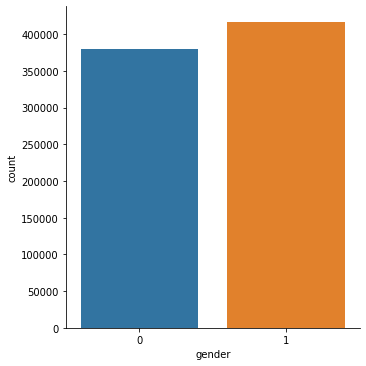

In [52]:
sns.catplot(data=complete_df,x='gender',kind='count')

The strategy we will use to predict the missing values is as follows :

- Starting from dataset that does not miss anything, we will fit a model that predicts either yob or gender. Since logically, the gender is highly related to the firstname, we chose to predict the gender, using yob, domain, firstname and zipcode, let's call this model model_1.

- We then use model_1 to predict the missing genders from the dataset that only misses genders. After the prediction, we concate the non missing dataset and the gender missing dataset plus the prediction. With this strategy, we get more training data.

- Having a larger dataset with non missing values now, we fit a regressor to predict yob, with the same principle as in the first step. We fit a model to predict yob, let's call it model_2.

- We use model_2 to predict missing yob values from the dataset that misses only yob, and we concate like usual.

- Now only the data that is missing both remains, we can proceed in two ways: either start by predicting gender, using (zipcode, domain and firstname) then predict yob using all 4 features (yob, gender, firstname and domain), or we can use only the 3 non missing features to predict both.

- With this, we have filled our dataset.

We first encode the gender, 1 is for male and 0 is for female.

In [13]:
encoding = {"gender":{'M' : 1, 'F':0}}
complete_df = complete_df.replace(encoding)
missing_yob = missing_yob.replace(encoding)
print(complete_df)
print(missing_yob)

          yob  domain  firstname  zipcode  gender
0        1985    39.0    10757.0   2244.0       0
1        1961    36.0     7717.0   1857.0       1
5        1975    39.0     5249.0   2172.0       1
6        1974    11.0    12976.0   1437.0       1
10       1961    11.0    10392.0   1484.0       1
...       ...     ...        ...      ...     ...
1999986  1973    10.0     7986.0    184.0       1
1999990  1959    17.0    10722.0    348.0       0
1999991  1998    18.0     2158.0   2108.0       0
1999995  1994    11.0      576.0   1357.0       0
1999996  1997    11.0     7851.0    113.0       1

[796719 rows x 5 columns]
         yob  domain  firstname  zipcode  gender
3         -1    16.0    12922.0   2214.0       1
8         -1    24.0    10046.0     73.0       1
13        -1    10.0    13172.0    366.0       1
18        -1    33.0     6742.0   1658.0       1
23        -1    17.0      829.0   2096.0       1
...      ...     ...        ...      ...     ...
1999978   -1    33.0    10392.

## Gender prediction

We divide our dataset into training and testing sets in order to be able to evaluate the model.

In [14]:
X = complete_df.iloc[:,0:complete_df.shape[1]-1]
y = complete_df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [15]:
print(X_test.head())

          yob  domain  firstname  zipcode
459035   1980    19.0     3211.0    141.0
194616   1979    33.0     2629.0    377.0
381995   1956    33.0     6244.0    492.0
1995110  1991    17.0    10929.0     77.0
1679996  1984    40.0     3170.0   1069.0


We first try a random forest with 100 estimator, normally the parameters should be tuned, but it takes too much time to do it, so we try several values by hand (done later for xgb model)

In [16]:
model = RandomForestClassifier(n_estimators=100,n_jobs=-1)
res=cross_validate(model,X,y,cv=4,scoring=('precision', 'recall','f1'),return_train_score=True)

To evaluate the model, we will take the mean of scores from a 4 folds cross validation. The metrics used are precision, recall and F1-score.

In [17]:
for i in res:
    print(i,' : ',res[i])
print('mean f1_score = ',np.mean(res['test_f1']))

fit_time  :  [33.75831985 31.1830802  29.528337   30.50311828]
score_time  :  [1.9974463  2.11321497 2.17545795 1.7283783 ]
test_precision  :  [0.88398446 0.87229736 0.85549292 0.86826746]
train_precision  :  [0.99955215 0.999645   0.99961618 0.99976013]
test_recall  :  [0.89925291 0.83071995 0.83540006 0.83888942]
train_recall  :  [0.99888751 0.9991976  0.99907932 0.99931908]
test_f1  :  [0.89155332 0.85100112 0.84532711 0.85332566]
train_f1  :  [0.99921972 0.99942125 0.99934768 0.99953956]
mean f1_score =  0.8603018021604915


We can view the variable importance in the splitting process, where it shows that the importance of yob is low for this task.

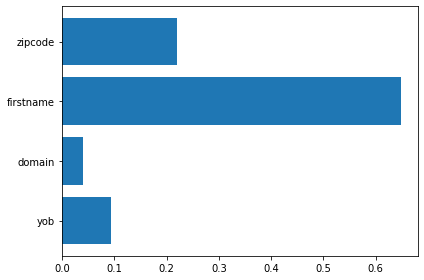

In [18]:
model.fit(X_train,y_train)
features = X_test.columns
importance = model.feature_importances_
plt.barh(np.arange(importance.size), importance)
plt.yticks(np.arange(importance.size), features)
plt.tight_layout()

## XGBoost classifier model
Normally, the hyperparameters should be hypertuned for example using a grid search cross validation, however this is not done since it takes too much time, instead, parameters were manually tested and the once who give the mean F1-score through a 4 folds cross validation were picked. 

In [19]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['binary:logistic']
    }

    xgb_model = XGBClassifier()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_


In [20]:
model = XGBClassifier(colsample_bytree = 0.5,
        learning_rate = 0.1,
        max_depth = 6,
        min_child_weight = 1,
        n_estimators = 1000,
        subsample = 0.7)
model.fit(X_train,y_train)

[06:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:


res=cross_validate(model,X,y,cv=4,scoring=('precision', 'recall','f1'),return_train_score=True)

[06:58:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:02:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:05:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [22]:
for i in res:
    print(i,' : ',res[i])
print('mean f1_score = ',np.mean(res['test_f1']))

fit_time  :  [129.55933285 135.26603985 135.4487586  125.96725965]
score_time  :  [0.85471582 0.97769284 0.82606792 0.83734584]
test_precision  :  [0.94756968 0.94384236 0.94005914 0.92694686]
train_precision  :  [0.94143555 0.94303793 0.94624657 0.95107852]
test_recall  :  [0.93873656 0.87282178 0.88424394 0.87398101]
train_recall  :  [0.88559262 0.90332212 0.89690933 0.90252323]
test_f1  :  [0.94313244 0.90694384 0.9112977  0.89968507]
train_f1  :  [0.91266067 0.92275288 0.92091762 0.92616492]
mean f1_score =  0.9152647585228959


Since the XGboost classifier gives better scores than the random forest model, it will used for what comes next.

## Predicting missing gender values (yob not missing)

We now use the previously fitted model to predict the missing gender values, in the dataset here only gender values are missing

In [23]:
model.fit(X_train,y_train)

[07:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
columns = list(missing_gender.columns)
columns.remove('gender')
print(columns)
X_test = missing_gender[columns]
y_pred = model.predict(X_test)

['yob', 'domain', 'firstname', 'zipcode']


In [25]:
missing_gender['gender']=y_pred
print(missing_gender)

          yob  domain  firstname  zipcode  gender
2        1977    10.0     1393.0   1373.0       1
7        1957    10.0     7717.0   1948.0       1
12       1980    39.0    13318.0    626.0       0
17       1965    10.0     2629.0    530.0       1
22       1977    41.0     7518.0   1686.0       1
...       ...     ...        ...      ...     ...
1999977  1980    11.0      791.0   2105.0       1
1999982  1958    11.0    11132.0    565.0       0
1999987  1994    17.0    11047.0   1801.0       0
1999992  1979    11.0    12416.0   1686.0       1
1999997  1998    11.0      134.0    328.0       0

[403281 rows x 5 columns]


After this, we concate the non missing data set with the newly completed dataset.

In [26]:
new_df=pd.concat([complete_df,missing_gender])
print(new_df)
print(new_df.shape)


          yob  domain  firstname  zipcode  gender
0        1985    39.0    10757.0   2244.0       0
1        1961    36.0     7717.0   1857.0       1
5        1975    39.0     5249.0   2172.0       1
6        1974    11.0    12976.0   1437.0       1
10       1961    11.0    10392.0   1484.0       1
...       ...     ...        ...      ...     ...
1999977  1980    11.0      791.0   2105.0       1
1999982  1958    11.0    11132.0    565.0       0
1999987  1994    17.0    11047.0   1801.0       0
1999992  1979    11.0    12416.0   1686.0       1
1999997  1998    11.0      134.0    328.0       0

[1200000 rows x 5 columns]
(1200000, 5)


## Prediction of yob values

We will now use the newly completed dataset to fit a regressor that predicts the yob.

In [27]:
columns = list(missing_gender.columns)
columns.remove('yob')
X = new_df[columns]
y = new_df.yob

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train)

         domain  firstname  zipcode  gender
1984975    17.0    11371.0   1602.0       0
1540007    35.0     7357.0    677.0       1
1831312    17.0     7851.0    632.0       0
1799711    39.0     6897.0    564.0       0
701340     11.0    12754.0    240.0       1
...         ...        ...      ...     ...
276701     17.0     6897.0   1961.0       0
653276     11.0     5645.0    574.0       0
331020     16.0     8183.0    553.0       1
1685945    11.0     2509.0   1695.0       1
306025     17.0     8489.0    504.0       0

[900000 rows x 4 columns]


In [28]:
model = XGBRegressor(colsample_bytree = 0.5,
        learning_rate = 0.1,
        max_depth = 6,
        min_child_weight = 1,
        n_estimators = 1000,
        subsample = 0.7)

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
y_pred=model.predict(X_test).astype(int)


In [30]:
print('Root mean squared error = ',np.sqrt(mean_squared_error(y_pred,y_test)))
print('Mean absolute error = ',mean_absolute_error(y_pred,y_test))    

Root mean squared error =  10.815731906194175
Mean absolute error =  7.960876666666667


The Mean absolute error is quite high, but this is kind of normal, since the features used are not highly indictive of the age (therefore year of birth) of a person. Let us view it's ditribution.

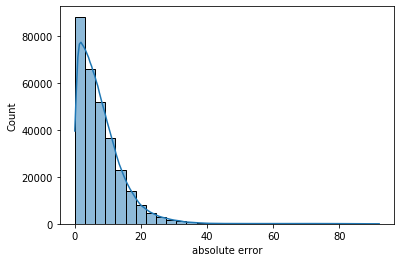

In [31]:
absolute_error=pd.DataFrame()
absolute_error['absolute error']=list(abs(y_pred-y_test))
sns.histplot(absolute_error,x="absolute error",bins=30,kde=True)

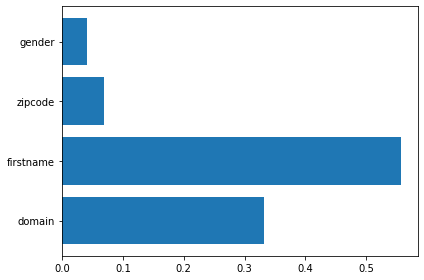

In [32]:
features = X_test.columns
importance = model.feature_importances_
plt.barh(np.arange(importance.size), importance)
plt.yticks(np.arange(importance.size), features)
plt.tight_layout()

Like in the case of gender where the importance of yob is low, we can see that the importance of gender is low when it comes to prediction the value yob.

Let us now predict the missing yob values, and concate all our completed dataset to get an even bigger complete dataset.

In [33]:
columns = list(missing_yob.columns)
columns.remove('yob')
print(columns)
X_test = missing_yob[columns]
print(X_test)
y_pred = model.predict(X_test)

['domain', 'firstname', 'zipcode', 'gender']
         domain  firstname  zipcode  gender
3          16.0    12922.0   2214.0       1
8          24.0    10046.0     73.0       1
13         10.0    13172.0    366.0       1
18         33.0     6742.0   1658.0       1
23         17.0      829.0   2096.0       1
...         ...        ...      ...     ...
1999978    33.0    10392.0   1688.0       0
1999983    33.0    13619.0   2139.0       0
1999988    11.0    11954.0   1257.0       0
1999993    11.0     2780.0   1884.0       0
1999998    16.0    13612.0    403.0       1

[398327 rows x 4 columns]


In [34]:
missing_yob['yob']=y_pred.astype(int)
print(missing_yob)

          yob  domain  firstname  zipcode  gender
3        1976    16.0    12922.0   2214.0       1
8        1977    24.0    10046.0     73.0       1
13       1954    10.0    13172.0    366.0       1
18       1968    33.0     6742.0   1658.0       1
23       1983    17.0      829.0   2096.0       1
...       ...     ...        ...      ...     ...
1999978  1957    33.0    10392.0   1688.0       0
1999983  1981    33.0    13619.0   2139.0       0
1999988  1990    11.0    11954.0   1257.0       0
1999993  1978    11.0     2780.0   1884.0       0
1999998  1982    16.0    13612.0    403.0       1

[398327 rows x 5 columns]


In [35]:
new_df=pd.concat([new_df,missing_yob])
print(new_df)
print(new_df.shape[0]+missing_both.shape[0])

          yob  domain  firstname  zipcode  gender
0        1985    39.0    10757.0   2244.0       0
1        1961    36.0     7717.0   1857.0       1
5        1975    39.0     5249.0   2172.0       1
6        1974    11.0    12976.0   1437.0       1
10       1961    11.0    10392.0   1484.0       1
...       ...     ...        ...      ...     ...
1999978  1957    33.0    10392.0   1688.0       0
1999983  1981    33.0    13619.0   2139.0       0
1999988  1990    11.0    11954.0   1257.0       0
1999993  1978    11.0     2780.0   1884.0       0
1999998  1982    16.0    13612.0    403.0       1

[1598327 rows x 5 columns]
2000000


## Predicting on data missing both yob and gender

Since we saw that the respective importance of one missing feature is low when it comes to predict the other features, we will fit two models, one to predict yob, the other to predict the gender, using only the 3 non missing features (therefore not using yob or gender)

In [36]:
cols=list(new_df.columns)
for e in ['gender','yob']:
    cols.remove(e)
print(cols)
X=new_df[cols]
targets=[list(new_df['gender']),list(new_df['yob'])]
y=[i for i in range(X.shape[0])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

['domain', 'firstname', 'zipcode']


In [37]:
y_gender_train = [targets[0][i] for i in y_train]
y_gender_test = [targets[0][i] for i in y_test]
y_yob_train = [targets[1][i] for i in y_train]
y_yob_test = [targets[1][i] for i in y_test]
print(len(y_yob_test),'   ',len(y_yob_train))

399582     1198745


We first start by predicting the values of yob.

In [38]:
model_yob = XGBRegressor(colsample_bytree = 0.5,
        learning_rate = 0.1,
        max_depth = 6,
        min_child_weight = 1,
        n_estimators = 1000,
        subsample = 0.7)
model_gender = XGBClassifier(colsample_bytree = 0.5,
        learning_rate = 0.1,
        max_depth = 6,
        min_child_weight = 1,
        n_estimators = 1000,
        subsample = 0.7)

In [39]:
model_yob.fit(X_train,y_yob_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
y_pred = model_yob.predict(X_test)
print('Mean absolute error = ',mean_absolute_error(y_pred,y_yob_test))
print('Root mean squared error = ',np.sqrt(mean_squared_error(y_pred,y_yob_test)))

Mean absolute error =  6.372346075525877
Root mean squared error =  9.54102104955198


We now inject the predicted values of yob.

In [41]:
X_s = missing_both[cols]
fill_yob = model_yob.predict(X_s)
missing_both['yob']=fill_yob.astype(int)
print(missing_both)

          yob  domain  firstname  zipcode gender
4        1982    11.0    11559.0   1812.0    NaN
9        1967    39.0     5769.0   1505.0    NaN
14       1975    40.0      758.0   1679.0    NaN
19       1967     7.0     2548.0   1437.0    NaN
24       1970    39.0    10802.0   2096.0    NaN
...       ...     ...        ...      ...    ...
1999979  1960     4.0    14371.0   1987.0    NaN
1999984  1981    11.0     1015.0   2245.0    NaN
1999989  1980    36.0    13930.0   2006.0    NaN
1999994  1979    33.0     5171.0    778.0    NaN
1999999  1960    33.0    14772.0    105.0    NaN

[401673 rows x 5 columns]


And we do the same thing with the gender.

In [42]:
model_gender.fit(X_train,y_gender_train)

[07:17:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
y_pred = model_gender.predict(X_test)
print('Precision = ',precision_score(y_pred,y_gender_test))
print('Recall = ',recall_score(y_pred,y_gender_test))
print('F1 score = ',f1_score(y_pred,y_gender_test))

Precision =  0.9090952964682489
Recall =  0.9438084024350527
F1 score =  0.9261266842186774


In [44]:
X_s = missing_both[cols]
fill_gender = model_gender.predict(X_s)
missing_both['gender']=fill_gender.astype(int)
print(missing_both)

          yob  domain  firstname  zipcode  gender
4        1982    11.0    11559.0   1812.0       1
9        1967    39.0     5769.0   1505.0       1
14       1975    40.0      758.0   1679.0       1
19       1967     7.0     2548.0   1437.0       0
24       1970    39.0    10802.0   2096.0       1
...       ...     ...        ...      ...     ...
1999979  1960     4.0    14371.0   1987.0       1
1999984  1981    11.0     1015.0   2245.0       0
1999989  1980    36.0    13930.0   2006.0       1
1999994  1979    33.0     5171.0    778.0       1
1999999  1960    33.0    14772.0    105.0       0

[401673 rows x 5 columns]


As we have completed all the values, we transform the resulting dataframe into it's original format, without the encodings.

In [45]:
filled_df = pd.concat([new_df,missing_both])
print(filled_df.dtypes)
reverse_encoding = {'gender': {1: 'M', 0: 'F'}}
filled_df = filled_df.replace(reverse_encoding)


yob            int64
domain       float64
firstname    float64
zipcode      float64
gender         int64
dtype: object


In [46]:
df=pd.read_csv("user_exo_2M.csv")
final_df = pd.concat([filled_df['yob'],df[cols],filled_df['gender']],axis=1)
print(final_df.sort_index())

          yob        domain        firstname  zipcode gender
0        1985   @wanadoo.fr  b08253b305fb5ec  94450.0      F
1        1961       @sfr.fr  7ff135854376850  78580.0      M
2        1977      @free.fr  172522ec1028ab7  62640.0      M
3        1976  @hotmail.com  d3ca5dde60f88db  94100.0      M
4        1982    @gmail.com  bdaae16837dd576  78100.0      M
...       ...           ...              ...      ...    ...
1999995  1994    @gmail.com  09f96867a8dc816  62400.0      F
1999996  1997    @gmail.com  823fec7a2632ea7   7200.0      M
1999997  1998    @gmail.com  029f0f59eba0903  21000.0      F
1999998  1982  @hotmail.com  deb97a759ee7b8b  26240.0      M
1999999  1960    @orange.fr  f11d689dda42279   6670.0      F

[2000000 rows x 5 columns]


The final result is stored in a csv file.

In [48]:
final_df.sort_index().to_csv('filled_data.csv',index=False)